<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/DDarrigo-Brick/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libaraies

In [82]:


# Install required libraries
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch astroquery ipytest pytest



# Imports

In [83]:
import ipytest
import pytest
ipytest.autoconfig()

In [133]:
#---------Basic Imports-----------#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from io import BytesIO

#---------ML Imports-----------#
import sklearn
from skimage.draw import disk
from sklearn.preprocessing import LabelEncoder
import auto_stretch
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import requests
from tqdm import tqdm
from random import randint
#---------Astropy Imports-----------#
import astroquery
from astroquery.simbad import Simbad
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.stats import mad_std
import photutils
from photutils.detection import DAOStarFinder
import auto_stretch
from auto_stretch import apply_stretch




# Data Preperation

## Loading Fits File

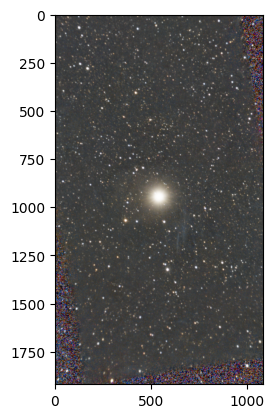

In [85]:

fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/1.fits"
# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
star_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(star_data))


## Finding Stars

In [86]:

bkg_sigma = mad_std(np.mean(star_data, axis=2))

daofind = DAOStarFinder(fwhm=3.0, threshold=20. * bkg_sigma, min_separation = 15)

sources = daofind(np.mean(star_data, axis=2))

catalog = sources.to_pandas().sort_values('flux', ascending=False).head(10)
# display(catalog)
catalog = sources.to_pandas().sort_values('flux', ascending=False).head(100)


# Sort by brightness (flux) in descending order
sorted_sources = sources.copy()
sorted_sources.sort('flux')         # sorts in ascending order
sorted_sources.reverse()            # flip to descending

# Take the top 10
top10 = catalog.sort_values('flux', ascending=False).head(10)
display(top10)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
331,332,538.971993,947.086537,0.382615,0.017168,-0.002670,25,0.656177,15.343670,-2.964823,-5.041669
442,443,583.739386,1325.966443,0.433907,0.522637,0.370925,25,0.279470,3.747173,-1.434259,-6.293021
363,364,366.068585,1070.867362,0.488784,0.502454,0.109203,25,0.211618,2.557206,-1.019414,-6.039289
568,569,997.759439,1826.184353,0.490058,0.829598,0.755707,25,0.118565,1.593300,-0.505744,-5.367977
366,367,566.542521,1077.921966,0.460210,0.605138,0.086204,25,0.110103,1.289240,-0.275835,-5.457801
105,106,168.013492,281.766062,0.465624,0.372571,-0.266440,25,0.080388,1.243665,-0.236758,-4.652623
149,150,418.645772,408.165121,0.435457,0.624704,0.193979,25,0.081892,1.019223,-0.020673,-5.077235
643,644,294.021260,1903.971581,0.327509,0.152530,0.967534,25,0.056870,0.969991,0.033080,-4.258799
24,25,124.415682,69.620651,0.452138,0.540998,0.379089,25,0.051294,0.808203,0.231199,-4.158733
434,435,732.039212,1314.148554,0.475732,0.681153,0.314722,25,0.056317,0.724774,0.349493,-4.542689


In [87]:

#Converting to real coordinaites
wcs = WCS(hdul[0].header, naxis=2)
print(wcs)
#append real coordinates to table
sky_coords = wcs.all_pix2world(catalog['xcentroid'],catalog['ycentroid'],1,ra_dec_order=True)
catalog['ra'] = sky_coords[0]
catalog['dec'] = sky_coords[1]
display(catalog)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 79.1719340780092 46.0087592970223 
CRPIX : 540.0 960.0 
PC1_1 PC1_2  : 0.999797158835514 -0.0201405358527186 
PC2_1 PC2_2  : 0.0201622861616532 0.999796720447079 
CDELT : -0.00110890832843152 0.00110891393928793 
NAXIS : 1080  1920  3


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec
331,332,538.971993,947.086537,0.382615,0.017168,-0.002670,25,0.656177,15.343670,-2.964823,-5.041669,79.173159,45.994419
442,443,583.739386,1325.966443,0.433907,0.522637,0.370925,25,0.279470,3.747173,-1.434259,-6.293021,79.113452,46.415458
363,364,366.068585,1070.867362,0.488784,0.502454,0.109203,25,0.211618,2.557206,-1.019414,-6.039289,79.453744,46.127441
568,569,997.759439,1826.184353,0.490058,0.829598,0.755707,25,0.118565,1.593300,-0.505744,-5.367977,78.456566,46.977002
366,367,566.542521,1077.921966,0.460210,0.605138,0.086204,25,0.110103,1.289240,-0.275835,-5.457801,79.133265,46.140085
...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,424,604.279584,1281.381908,0.456402,0.573255,0.191930,25,0.006954,0.105060,2.446404,-2.097144,79.079061,46.366467
452,453,513.997703,1381.357150,0.463482,0.358706,0.336078,25,0.006799,0.104932,2.447726,-2.013721,79.227458,46.475308
513,514,50.099663,1644.984986,0.466730,-0.631390,0.083119,25,0.006899,0.104252,2.454787,-2.142265,79.986946,46.754305
63,64,746.780983,158.064334,0.437750,0.413083,0.327286,25,0.006449,0.103021,2.467684,-1.924289,78.821675,45.123821


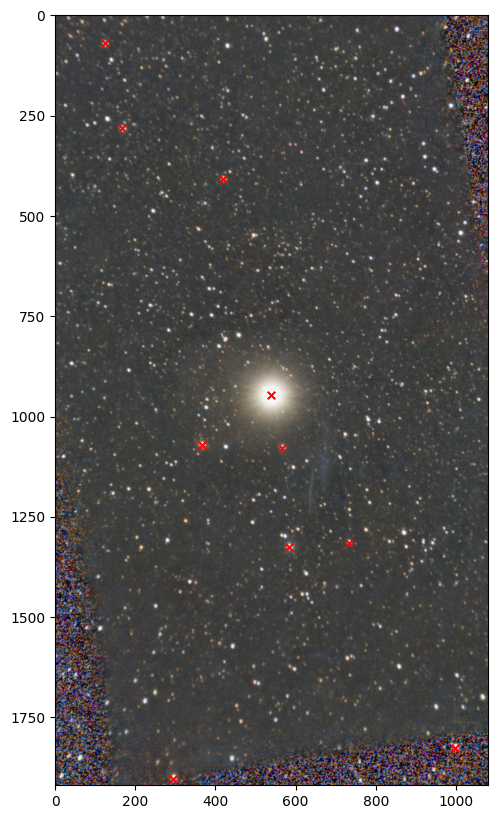

In [88]:

fig = plt.figure(figsize=(10,10))
plt.imshow(apply_stretch(star_data))

plt.scatter(top10['xcentroid'],top10['ycentroid'], color='red',marker= 'x',s=30)
plt.show()

## Classifying Spectral Type

In [89]:
options = Simbad.list_votable_fields()



Simbad.reset_votable_fields()
Simbad.add_votable_fields("mesdistance","V", "sp", "otype", "ids")

for idx, row in tqdm(catalog.iterrows(), total=catalog.shape[0]):
  ra, dec = row["ra"], row["dec"]
  coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
  print(coord)
  try:
    result = Simbad.query_region(coord, radius="100s")
    if result:
      catalog.at[idx, "star_name"] = result[0]["main_id"]
      catalog.at[idx, "spectral_type"] = result[0]["sp_type"]
      catalog.at[idx, "object_type"] = result[0]["otype"]
      catalog.at[idx, "visual_mag"] = result[0]["V"]

      dist = result[0]["mesdistance.dist"]
      catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None

  except Exception as e:
    print(f"Error querying Simbad for {idx}: {e}")
catalog.to_csv('catalog.csv', index=False)
display(catalog)



  9%|▉         | 9/100 [00:00<00:01, 83.89it/s]<ipython-input-89-0b93539faa8e>:21: UserWarning: Warning: converting a masked element to nan.
  catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/base.py:363: UserWarning: Warning: converting a masked element to nan.
  arr[indexer] = value


<SkyCoord (ICRS): (ra, dec) in deg
    (79.17315948, 45.9944193)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.11345249, 46.41545829)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.45374397, 46.12744144)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.45656593, 46.97700215)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.13326529, 46.14008472)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.73614038, 45.24714783)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.34596865, 45.39412445)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.60304197, 47.04890668)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.79542856, 45.01071839)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.8746459, 46.40530187)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.29907707, 45.82652718)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.41540989, 45.55413428)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.65535574, 46.38108323)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.79517565, 45.21989779)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.36007971, 46.13469889

 36%|███▌      | 36/100 [00:00<00:00, 119.79it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (79.9806835, 46.98559892)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.13136186, 46.38495377)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.23161638, 45.55150297)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.60209202, 46.3891314)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.37800631, 45.8558928)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.62515697, 45.47765732)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.74201437, 45.41233689)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.88269839, 46.62800822)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.38418181, 45.13186136)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.35109599, 45.83608914)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.68243353, 46.75080007)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.55293079, 45.34233665)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.34648199, 46.83820518)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.96394563, 45.89302711)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.37773327, 45.00910516)

 82%|████████▏ | 82/100 [00:00<00:00, 187.01it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (78.53497825, 46.86352363)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.77366744, 45.05656833)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.35099041, 46.68708013)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.39824307, 45.52578906)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.70996944, 46.8324602)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.44808477, 45.53125276)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.35075993, 46.01488913)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.36410806, 46.99734431)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.89023257, 46.72587791)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.55769487, 45.30594363)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.64733503, 46.41990456)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.94609739, 45.15360023)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.06715092, 46.54662095)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.75157389, 46.24436287)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.4499952, 46.77746332

100%|██████████| 100/100 [00:00<00:00, 149.08it/s]


<SkyCoord (ICRS): (ra, dec) in deg
    (79.2274582, 46.47530802)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.98694571, 46.75430544)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.82167483, 45.12382064)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.24878102, 45.77341529)>


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,simbad_distance_pc
331,332,538.971993,947.086537,0.382615,0.017168,-0.002670,25,0.656177,15.343670,-2.964823,-5.041669,79.173159,45.994419,* alf Aur,G3III:,SB*,0.08,13.000
442,443,583.739386,1325.966443,0.433907,0.522637,0.370925,25,0.279470,3.747173,-1.434259,-6.293021,79.113452,46.415458,* 12 Aur,B2Ve,Be*,6.95,655.136
363,364,366.068585,1070.867362,0.488784,0.502454,0.109203,25,0.211618,2.557206,-1.019414,-6.039289,79.453744,46.127441,HD 34190,K3III,V*,7.25,769.704
568,569,997.759439,1826.184353,0.490058,0.829598,0.755707,25,0.118565,1.593300,-0.505744,-5.367977,78.456566,46.977002,HD 33601B,,*,10.67,716.127
366,367,566.542521,1077.921966,0.460210,0.605138,0.086204,25,0.110103,1.289240,-0.275835,-5.457801,79.133265,46.140085,BD+45 1076,F0,PM*,8.06,104.307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,424,604.279584,1281.381908,0.456402,0.573255,0.191930,25,0.006954,0.105060,2.446404,-2.097144,79.079061,46.366467,NaN,NaN,NaN,NaN,NaN
452,453,513.997703,1381.357150,0.463482,0.358706,0.336078,25,0.006799,0.104932,2.447726,-2.013721,79.227458,46.475308,NaN,NaN,NaN,NaN,NaN
513,514,50.099663,1644.984986,0.466730,-0.631390,0.083119,25,0.006899,0.104252,2.454787,-2.142265,79.986946,46.754305,TYC 3358-48-1,,*,11.05,411.624
63,64,746.780983,158.064334,0.437750,0.413083,0.327286,25,0.006449,0.103021,2.467684,-1.924289,78.821675,45.123821,TYC 3358-1315-1,,*,11.30,344.911


In [90]:
catalog['spectral_type'].notna().sum()
catalog = pd.read_csv('catalog.csv', index_col=0)
catalog['spectral_type'].unique()



array(['G3III:', 'B2Ve', 'K3III', nan, 'F0', 'G5', 'A0', 'B7V', 'F5',
       'A2', 'A', 'M2', 'F0V', 'G0III', 'G2V', 'K0', 'F8', 'G2IV'],
      dtype=object)

In [91]:
# Simplyfy Star Classes for easier analyzisis
def extract_spectral_class(s):
    """ simplify sepctral classes, e.g. M1 --> M """
    if s is np.nan:
        return s
    return s[0]


catalog['spectral_label'] = catalog['spectral_type'].apply(extract_spectral_class)
catalog

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,simbad_distance_pc,spectral_label
id,,,,,,,,,,,,,,,,,,
332,538.971993,947.086537,0.382615,0.017168,-0.002670,25,0.656177,15.343670,-2.964823,-5.041669,79.173159,45.994419,* alf Aur,G3III:,SB*,0.08,13.000,G
443,583.739386,1325.966443,0.433907,0.522637,0.370925,25,0.279470,3.747173,-1.434259,-6.293021,79.113452,46.415458,* 12 Aur,B2Ve,Be*,6.95,655.136,B
364,366.068585,1070.867362,0.488784,0.502454,0.109203,25,0.211618,2.557206,-1.019414,-6.039289,79.453744,46.127441,HD 34190,K3III,V*,7.25,769.704,K
569,997.759439,1826.184353,0.490058,0.829598,0.755707,25,0.118565,1.593300,-0.505744,-5.367977,78.456566,46.977002,HD 33601B,NaN,*,10.67,716.127,NaN
367,566.542521,1077.921966,0.460210,0.605139,0.086204,25,0.110103,1.289240,-0.275835,-5.457801,79.133265,46.140085,BD+45 1076,F0,PM*,8.06,104.307,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,604.279584,1281.381908,0.456402,0.573255,0.191930,25,0.006954,0.105060,2.446404,-2.097144,79.079061,46.366467,NaN,NaN,NaN,NaN,NaN,NaN
453,513.997703,1381.357150,0.463482,0.358706,0.336078,25,0.006799,0.104932,2.447726,-2.013721,79.227458,46.475308,NaN,NaN,NaN,NaN,NaN,NaN
514,50.099663,1644.984986,0.466730,-0.631390,0.083119,25,0.006899,0.104252,2.454786,-2.142265,79.986946,46.754305,TYC 3358-48-1,NaN,*,11.05,411.624,NaN


# Visualizing Stars

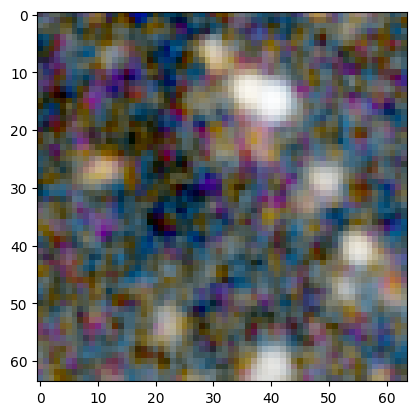

In [92]:
def make_patch(image, x,y, size = 64):
  x_min = int(np.clip(x-size/2, 0, image.shape[0]))
  x_max = int(np.clip(x+size/2, 0, image.shape[0]))
  y_min = int(np.clip(y-size/2, 0, image.shape[1]))
  y_max = int(np.clip(y+size/2, 0, image.shape[1]))
  return image[x_min:x_max, y_min:y_max]


plt.imshow(apply_stretch(make_patch(star_data, catalog['xcentroid'].iloc[0], catalog['ycentroid'].iloc[0])))

In [93]:
def make_patch(image, x, y, size=64):
    x = int(x)
    y = int(y)
    half_size = size // 2

    x_min = max(x - half_size, 0)
    x_max = min(x + half_size, image.shape[1])  # Changed image.shape[0] to image.shape[1] for x-axis
    y_min = max(y - half_size, 0)
    y_max = min(y + half_size, image.shape[0])  # Changed image.shape[1] to image.shape[0] for y-axis

    if x_min >= x_max or y_min >= y_max:
        print(f"Invalid patch coordinates: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")
        return np.zeros((size, size, image.shape[2]))  # Return empty patch with same channels
    else:
        patch = image[y_min:y_max, x_min:x_max, :]  # Swapped y_min:y_max and x_min:x_max for correct indexing
        return patch

    output_dir = "Star Pictures"


output_dir = "Star Pictures"
os.makedirs(output_dir, exist_ok=True)

for idx in range(10):
    x = catalog['xcentroid'].iloc[idx]
    y = catalog['ycentroid'].iloc[idx]

    patch = make_patch(star_data, x, y, size=64)

    # Skip if patch is empty
    if patch.size == 0:
        print(f"Skipping index {idx} due to empty patch.")
        continue

    stretched_patch = apply_stretch(patch)

    fig, ax = plt.subplots(figsize=(2,2))
    ax.imshow(stretched_patch, cmap='gray')
    ax.axis('off')

    filename = os.path.join(output_dir, f"star_patch_{idx}.png")
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)


In [94]:
#Re-classify top 10 with spectral class
top10 = catalog.sort_values('flux', ascending=False).head(10)

labels = []
for idx, row in top10.iterrows():
    morph = "star"  # assume all 10 are stars

    spec_class = row['spectral_type'][0] if pd.notna(row['spectral_type']) else "Unknown"

    labels.append({
        "patch_id": idx,
        "morphology": morph,
        "spectral_class": spec_class
    })

labels

[{'patch_id': 332, 'morphology': 'star', 'spectral_class': 'G'},
 {'patch_id': 443, 'morphology': 'star', 'spectral_class': 'B'},
 {'patch_id': 364, 'morphology': 'star', 'spectral_class': 'K'},
 {'patch_id': 569, 'morphology': 'star', 'spectral_class': 'Unknown'},
 {'patch_id': 367, 'morphology': 'star', 'spectral_class': 'F'},
 {'patch_id': 106, 'morphology': 'star', 'spectral_class': 'Unknown'},
 {'patch_id': 150, 'morphology': 'star', 'spectral_class': 'Unknown'},
 {'patch_id': 644, 'morphology': 'star', 'spectral_class': 'G'},
 {'patch_id': 25, 'morphology': 'star', 'spectral_class': 'A'},
 {'patch_id': 435, 'morphology': 'star', 'spectral_class': 'B'}]

## Artifical Soruces

In [149]:
# Function to generate a patch of an extended source (e.g., galaxy or nebula)
def generate_extended_source(size=64):
    image = np.zeros((size, size))
    rr, cc = disk((size // 2, size // 2), size // 4, shape=image.shape)
    image[rr, cc] = 1  # Simulate an extended source (like a nebula)
    return image

# Function to generate an artifact (e.g., hot pixel or cosmic ray)
def generate_artifact(size=64):
    image = np.zeros((size, size))
    x, y = randint(0, size-1), randint(0, size-1)
    image[x, y] = 255  # A hot pixel
    return image

# Function to generate a cosmic ray (bright line or spot)
def generate_cosmic_ray(size=64):
    image = np.zeros((size, size))
    x_start = randint(0, size-10)
    x_end = x_start + 50
    y = randint(0, size)
    image[x_start:x_end, y] = 255  # A vertical cosmic ray line
    return image

# Function to create labels for patches
def label_patch(morphology, brightness_class="N/A", spectral_class="N/A"):
    return {
        "morphology": morphology,
        "brightness_class": brightness_class,
        "spectral_class": spectral_class
    }

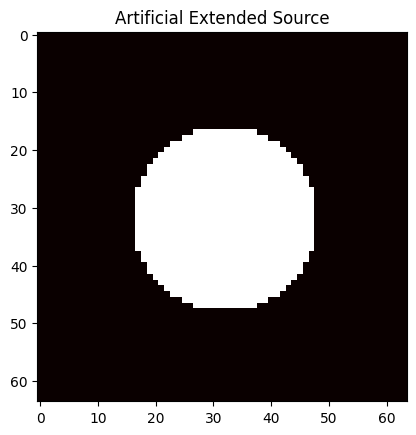

In [147]:

extended_example = generate_extended_source()
plt.imshow(extended_example, cmap='hot')
plt.title("Artificial Extended Source")
plt.show()


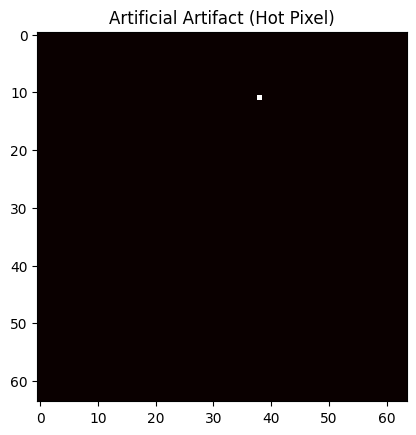

In [96]:

artifact_example = generate_artifact()
plt.imshow(artifact_example, cmap='hot')
plt.title("Artificial Artifact (Hot Pixel)")
plt.show()

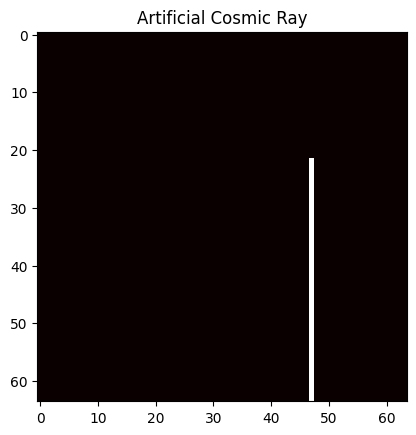

In [150]:
ray_example = generate_cosmic_ray()
plt.imshow(ray_example, cmap='hot')
plt.title("Artificial Cosmic Ray")
plt.show()

## Drawing Patches

In [143]:
from PIL import Image

from sklearn.model_selection import train_test_split



# Create a directory to store the patches if it doesn't exist
output_dir = "Patches"
os.makedirs(output_dir, exist_ok=True)

# Function to save images
def save_image(image_array, filename, output_dir):
    image = Image.fromarray(image_array.astype(np.uint8))  # Convert to uint8 for PIL
    image.save(os.path.join(output_dir, filename))

# Generate and save patches for the top 10 objects
patches = [] # Initialize an empty list to store patches
for i in range(10):
    patch = make_patch(star_data, top10['xcentroid'].iloc[i], top10['ycentroid'].iloc[i])

    # Check if the patch has the expected shape before applying stretch and saving
    if patch.shape == (64, 64, 3):  # Adjust shape if necessary
        stretched_patch = apply_stretch(patch)
        save_image(stretched_patch, f"star_patch_{i}.png", output_dir)
        patches.append(stretched_patch) # Append each patch to the list
    else:
        print(f"Skipping patch {i} due to unexpected shape: {patch.shape}")


# Generate and save artificial sources
# Extended source
extended_source = generate_extended_source(size=64)
save_image(extended_source, f"extended_source.png", output_dir)
# Reshape extended_source to match the expected shape
extended_source = np.stack([extended_source]*3, axis=-1)  # Stack to create 3 channels
patches.append(extended_source) # Add extended source to patches

# Artifact (hot pixel)
artifact_example = generate_artifact(size=64)
save_image(artifact_example, f"artifact_example.png", output_dir)
# Reshape artifact_example to match the expected shape
artifact_example = np.stack([artifact_example]*3, axis=-1)  # Stack to create 3 channels
patches.append(artifact_example)  # Add artifact example to patches


# Update the labels to include the artificial examples
labels.append({
    "patch_id": "extended",
    "morphology": "extended",
    "spectral_class": "Unknown" # or provide a class if relevant
})
labels.append({
    "patch_id": "artifact",
    "morphology": "artifact",
    "spectral_class": "Unknown" # or provide a class if relevant
})

# Display the labels
display(labels)

Skipping patch 7 due to unexpected shape: (49, 64, 3)


[{'patch_id': 332, 'morphology': 'star', 'spectral_class': 'G'},
 {'patch_id': 443, 'morphology': 'star', 'spectral_class': 'B'},
 {'patch_id': 364, 'morphology': 'star', 'spectral_class': 'K'},
 {'patch_id': 569, 'morphology': 'star', 'spectral_class': 'Unknown'},
 {'patch_id': 367, 'morphology': 'star', 'spectral_class': 'F'},
 {'patch_id': 106, 'morphology': 'star', 'spectral_class': 'Unknown'},
 {'patch_id': 150, 'morphology': 'star', 'spectral_class': 'Unknown'},
 {'patch_id': 644, 'morphology': 'star', 'spectral_class': 'G'},
 {'patch_id': 25, 'morphology': 'star', 'spectral_class': 'A'},
 {'patch_id': 435, 'morphology': 'star', 'spectral_class': 'B'},
 {'patch_id': 'extended',
  'morphology': 'extended',
  'spectral_class': 'Unknown'},
 {'patch_id': 'artifact',
  'morphology': 'artifact',
  'spectral_class': 'Unknown'},
 {'patch_id': 'extended',
  'morphology': 'extended',
  'spectral_class': 'Unknown'},
 {'patch_id': 'artifact',
  'morphology': 'artifact',
  'spectral_class': '

# Machine Contruction and Traning

In [136]:
num_classes = 7

model = Sequential()


model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)))

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


catalog['spectral_type'].unique()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


array(['G3III:', 'B2Ve', 'K3III', nan, 'F0', 'G5', 'A0', 'B7V', 'F5',
       'A2', 'A', 'M2', 'F0V', 'G0III', 'G2V', 'K0', 'F8', 'G2IV'],
      dtype=object)

In [131]:
# Convert spectral types to numerical labels
spectral_mapping = {
    spectral_type: i for i, spectral_type in enumerate(catalog['spectral_label'].unique())
}
catalog['spectral_label_encoded'] = catalog['spectral_label'].map(spectral_mapping)

# Prepare data
x = np.array(patches)  # Changed X to x
# Create an empty list to store labels
y = []
# Add spectral labels for the real objects
y.extend(catalog['spectral_label_encoded'].head(10).tolist())

# Add labels for artificial objects
# Assuming 'Unknown' for artificial objects, get the encoded value for 'Unknown' or NaN
unknown_label = spectral_mapping.get(np.nan, -1)  # -1 if NaN is not in spectral_mapping

# Add unknown_label to y for each artificial object
y.extend([unknown_label, unknown_label])

# Ensure y has the same length as x
# Check if the length of labels y does not match the length of patches x.
if len(y) != len(x): # Changed X to x
    # Adjust labels y to match the length of patches x.
    y = y[:len(x)]  # Trim or pad y to the length of x # Changed X to x

y = np.array(y)  # Convert y to a NumPy array


# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11) # Changed X to x

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test)) # Changed X to x

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1250 - loss: 1.9653 - val_accuracy: 0.0000e+00 - val_loss: 1.8059
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5000 - loss: 1.8811 - val_accuracy: 0.0000e+00 - val_loss: 1.6914
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1250 - loss: 1.8353 - val_accuracy: 0.6667 - val_loss: 1.5249
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3750 - loss: 1.7579 - val_accuracy: 0.3333 - val_loss: 1.3940
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.0000e+00 - loss: 1.7059 - val_accuracy: 0.3333 - val_loss: 1.4006
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5000 - loss: 1.6290 - val_accuracy: 0.3333 - val_loss: 1.4853
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2500 - loss: 1.6441 - val_accuracy: 0.3333 - val_loss: 1.6106
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5000 - loss: 1.5025 - val_accuracy: 0.3333 - 

In [139]:
le = LabelEncoder()
catalog['spectral_label'] = le.fit_transform(catalog['spectral_label'])
catalog.head()

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,simbad_distance_pc,spectral_label,spectral_label_encoded
id,,,,,,,,,,,,,,,,,,,
332,538.971993,947.086537,0.382615,0.017168,-0.002670,25,0.656177,15.343670,-2.964823,-5.041669,79.173159,45.994419,* alf Aur,G3III:,SB*,0.08,13.000,3,0
443,583.739386,1325.966443,0.433907,0.522637,0.370925,25,0.279470,3.747173,-1.434259,-6.293021,79.113452,46.415458,* 12 Aur,B2Ve,Be*,6.95,655.136,1,1
364,366.068585,1070.867362,0.488784,0.502454,0.109203,25,0.211618,2.557206,-1.019414,-6.039289,79.453744,46.127441,HD 34190,K3III,V*,7.25,769.704,4,2
569,997.759439,1826.184353,0.490058,0.829598,0.755707,25,0.118565,1.593300,-0.505744,-5.367977,78.456566,46.977002,HD 33601B,NaN,*,10.67,716.127,6,3
367,566.542521,1077.921966,0.460210,0.605139,0.086204,25,0.110103,1.289240,-0.275835,-5.457801,79.133265,46.140085,BD+45 1076,F0,PM*,8.06,104.307,2,4


## Training Loss

Skipping patch 7 due to unexpected shape: (49, 64, 3)
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.9468 - val_accuracy: 0.5000 - val_loss: 1.7914
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2857 - loss: 1.8727 - val_accuracy: 0.5000 - val_loss: 1.6698
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4286 - loss: 1.8110 - val_accuracy: 0.5000 - val_loss: 1.6724
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2857 - loss: 1.9709 - val_accuracy: 0.5000 - val_loss: 1.6537
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2857 - loss: 1.7723 - val_accuracy: 0.5000 - val_loss: 1.6514
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2857 - loss: 1.8436 - val_accuracy: 0.5000 - val_loss: 1.6415
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2857 - loss: 1.7976 - val_accuracy: 0.5000 - val_loss: 1.6670
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0

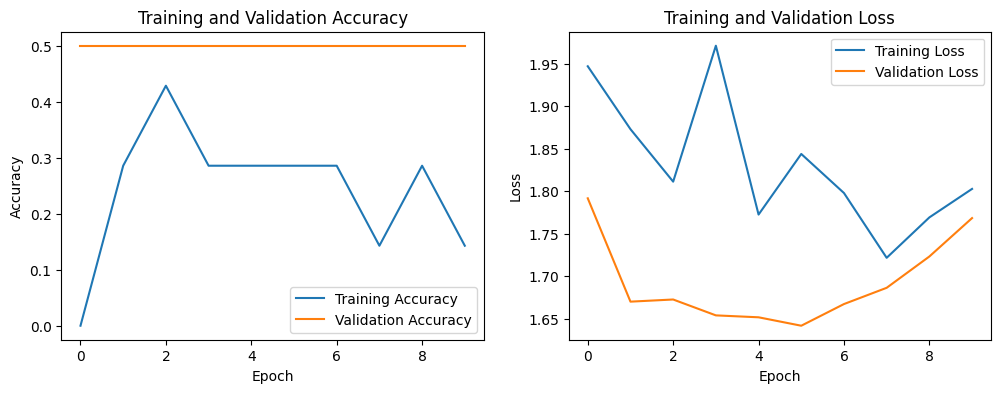

In [140]:


# Plot training and validation accuracy/loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
